# Exam scores
## Introduction
This is a data analysis project taking the concept from the DataCamp competition [Analyzing the effectiveness of test preparation courses](https://app.datacamp.com/learn/competitions/student-exam-scores) and the data from [Royce Kimmons data generators tools](http://roycekimmons.com/tools/generated_data/exams).


The data file has the following fields:
- "gender" - male / female
- "race/ethnicity" - one of 5 combinations of race/ethnicity
- "parent_education_level" -  highest education level of either parent
- "lunch" - whether the student receives free/reduced or standard lunch
- "test_prep_course" - whether the student took the test preparation course
- "math" -  exam score in math 
- "reading" -  exam score in reading 
- "writing" -  exam score in writing 

Ideally, we have been asked to create a report to answer some principal's questions:
1. What are the average scores for students with/without the test preparation course, and how effective is the test preparation course?
2. What are the average scores for the different parental education levels?
5. The principal wants to know if kids who perform well on one subject also score well on the others. Look at the correlations between scores. 
8. Which major factors contribute to test outcomes?
9. What would be the best way to improve student scores on each test?

I will try to answer this question during the project. I will not answer them explicitly, but surely you can find the answers while reading. I will provide my own insights and ideas, given what data tell me. Finally, I will tell what I would suggest to the principal in order to improve the tests results.

Since I can choose the size of the dataset, I am assuming that the school comprehend 1000 students.

## Preparation
In this section I import the packages I will need and the data I will use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
file_path = 'exams.csv'
colnames = ['gender', 'race', 'parental_education', 'lunch_fare', 'test_prep', 'math_score', 'reading_score', 'writing_score']
data = pd.read_csv(file_path, sep = ',', header = 0, names = colnames)

While importing, I changed the column names to make it easier to work and to read.

In [3]:
data.head()

,gender,race,parental_education,lunch_fare,test_prep,math_score,reading_score,writing_score
0,male,group C,bachelor's degree,free/reduced,none,43,45,41
1,female,group C,some high school,free/reduced,none,60,67,65
2,male,group E,high school,standard,completed,80,71,70
3,male,group C,some college,standard,none,73,71,66
4,female,group C,some college,standard,none,66,60,63


In [4]:
print('The shape of the dataset is: {}'.format(data.shape))

The shape of the dataset is: (1000, 8)


## Data Exploratory and Analysis
We give a look at the data.

In [8]:
print('Some information about the data\n')
print(data.info())
print(data.describe())

Some information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gender              1000 non-null   object
 1   race                1000 non-null   object
 2   parental_education  1000 non-null   object
 3   lunch_fare          1000 non-null   object
 4   test_prep           1000 non-null   object
 5   math_score          1000 non-null   int64 
 6   reading_score       1000 non-null   int64 
 7   writing_score       1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None
        math_score  reading_score  writing_score
count  1000.000000    1000.000000     1000.00000
mean     66.896000      70.271000       68.99500
std      16.023731      15.081944       15.73272
min      15.000000      21.000000       17.00000
25%      56.000000      60.000000       59.00000
50%      67.000000      71.00000

In [9]:
for column in data.columns:
    print('Column: {}\nNumber of different values: {}\nValues: {}\n'.format(
        column, data[column].unique().size, data[column].unique()
        ))

Column: gender
Number of different values: 2
Values: ['male' 'female']

Column: race
Number of different values: 5
Values: ['group C' 'group E' 'group D' 'group B' 'group A']

Column: parental_education
Number of different values: 6
Values: ["bachelor's degree" 'some high school' 'high school' 'some college'
 "associate's degree" "master's degree"]

Column: lunch_fare
Number of different values: 2
Values: ['free/reduced' 'standard']

Column: test_prep
Number of different values: 2
Values: ['none' 'completed']

Column: math_score
Number of different values: 76
Values: [ 43  60  80  73  66  79  58  26  89  53  86  57  68  67  82  63  92  84
  52  74  45  69  99  61  81  64  42  71  55  49  50 100  78  85  40  76
  56  97  70  54  88  46  72  75  59  87  51  41  93  62  90  77  44  48
  34  65  31  39  15  36  32  95  94  96  98  83  33  47  29  91  30  37
  35  38  20  25]

Column: reading_score
Number of different values: 72
Values: [ 45  67  71  60  75  56  48  73  54  96  57  74  79  

Three features are binary features, and **parental level of education** and **race/ethinicity** are categorical. The scores have large ranges - 21 to 100 the narrowest - but they are only integers. We don't have <code>nan</code> values. 

We note that for the **parental level of education** we have the categories of *'some high school'* and *'high school'*, thus I will merge them into one category in order to make analysis more accurate.

In [10]:
data['parental_education'].replace({'some high school' : 'high school'}, inplace = True)
print('Values of parental level of education after the replacement:\n{}'.format(data['parental_education'].unique()))

Values of parental level of education after the replacement:
["bachelor's degree" 'high school' 'some college' "associate's degree"
 "master's degree"]


### EDA
First, I will look if the scores on the different tests -math, reading and writing - are correlated.

#### Scores tests correlation

In [11]:
scores = data.loc[:, ['reading_score', 'writing_score', 'math_score']]

print(scores.corr())

               reading_score  writing_score  math_score
reading_score       1.000000       0.958888    0.832769
writing_score       0.958888       1.000000    0.820928
math_score          0.832769       0.820928    1.000000


We can see that the writing and reading scores are strongly correlated, and we have a good correlation with the math score for both. We can see better the results in the following plot.

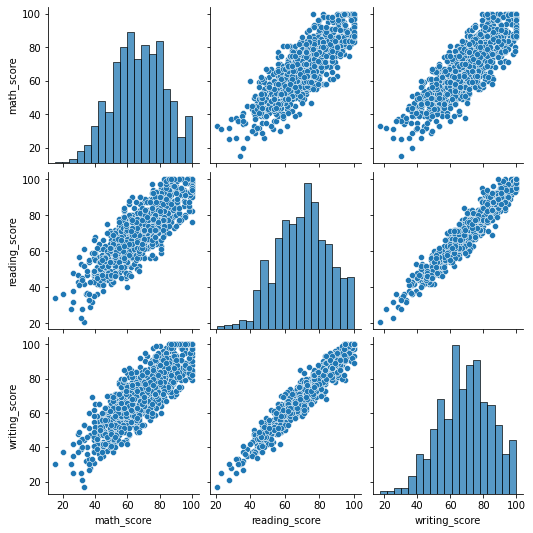

In [12]:
mask = ['math_score', 'reading_score', 'writing_score']

_ = sns.pairplot(data[mask])

We see also that the scores have a distribution similar to a normal distribution.

Next, I will create a new column named <code>total_score</code> summing the results obtained in the three tests.

In [13]:
data['total_score'] = data['reading_score'] + data['writing_score'] + data['math_score'] 
data.head()

,gender,race,parental_education,lunch_fare,test_prep,math_score,reading_score,writing_score,total_score
0,male,group C,bachelor's degree,free/reduced,none,43,45,41,129
1,female,group C,high school,free/reduced,none,60,67,65,192
2,male,group E,high school,standard,completed,80,71,70,221
3,male,group C,some college,standard,none,73,71,66,210
4,female,group C,some college,standard,none,66,60,63,189


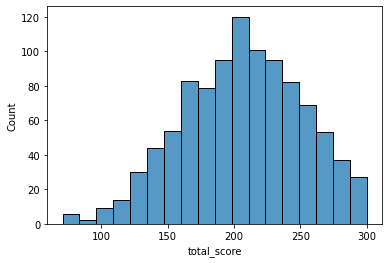

In [17]:
# plot the distribution of the total_score variable
_ = sns.histplot(data['total_score'], bins = 18)

The distribution of the total score is almost normal.
Now, I will look to how different features contribute to the outcome of the tests, using the <code>total_score</code> variable.

#### Average scores by test preparation completition
To answer the question: what are the average total scores for students with/without the test preparation course?

In [18]:
n_completed_test = (data['test_prep'] == 'completed').sum()
print('Number of students who completed the test: {}\nNumber of students who did not complete the test: {}'.format(
n_completed_test, data.shape[0] - n_completed_test))

Number of students who completed the test: 340
Number of students who did not complete the test: 660


In [19]:
round(data.groupby('test_prep')[['total_score']].mean(), 3)

,total_score
test_prep,
completed,222.668
none,197.659


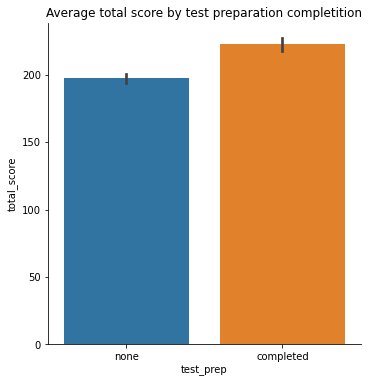

In [20]:
_ = sns.catplot(x = 'test_prep', y = 'total_score', data = data, kind = 'bar', estimator = np.mean)
_ = plt.title('Average total score by test preparation completition')

It seems that students who completed the test preparation course had better results on the overall scores. Let's do an hypothesis test to see if our hypothesis is correct.

The results of each students are our $X_1, \ldots, X_n$. We assume they are indipendent and identically distributed as $\mathcal{N}(\mu, \sigma)$ - it seems a correct assumption as we have seen from the plot before. $\mu$ and $\sigma$ are unknown, thus we use the test statistic 
$$
T = \frac{\bar X- \mu_0}{S/\sqrt{n}}\approx t_{n-1}
$$
under $H_0 : \mu > \mu_0$, where $\mu_0$ is the average total score of students who didn't take the test preparation course.

In [21]:
ttest = ttest_ind(data.loc[data['test_prep'] == 'completed', 'total_score'], data.loc[data['test_prep'] == 'none', 'total_score'], alternative = 'greater')
print('p-value of the hypothesis test is: {}'.format(ttest[1]))
print('We can reject the null hypothesis that mu_0 is greater or equal than mu')

p-value of the hypothesis test is: 8.226761321177595e-18
We can reject the null hypothesis that mu_0 is greater or equal than mu


The p-value confirms our intuition that who completed the test preparation course had better results on the overall scores. 

#### Average scores by different parental education levels
What are the average scores for the different parental education levels?

In [22]:
pt_scores = pd.pivot_table(data, index = 'parental_education', values = ['reading_score', 'writing_score', 'math_score', 'total_score'])
pt_scores.sort_values('total_score', inplace = True)
pt_scores = pt_scores.reindex(columns=['reading_score','writing_score', 'math_score','total_score'])
pt_scores.applymap(round)

,reading_score,writing_score,math_score,total_score
parental_education,,,,
high school,67,65,63,195
some college,71,70,69,210
bachelor's degree,72,71,68,211
associate's degree,72,71,68,211
master's degree,77,76,74,227


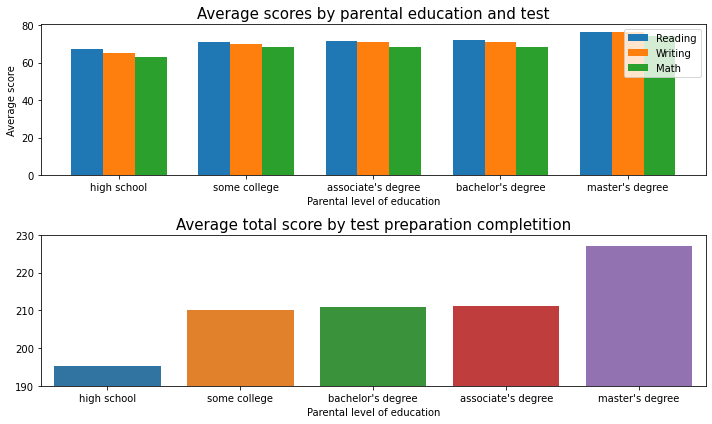

In [23]:
avg_scores = data.groupby('parental_education')[['reading_score', 'writing_score', 'math_score']].mean()
avg_scores = avg_scores.sort_values('reading_score')

labels = list(avg_scores.index)
x = np.arange(len(avg_scores.index))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(2, 1, figsize = (10, 6))

g1 = ax[0].bar(x-width, avg_scores['reading_score'], width = width, label='Reading')
g2 = ax[0].bar(x, avg_scores['writing_score'], width = width, label='Writing')
g3 = ax[0].bar(x+width, avg_scores['math_score'], width = width, label='Math')

ax[0].set_ylabel('Average score')
ax[0].set_title('Average scores by parental education and test', fontsize = 15)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_xlabel('Parental level of education')
ax[0].legend()

avg_total = data.groupby('parental_education')['total_score'].mean()
avg_total = avg_total.sort_values()
g4 = sns.barplot(ax = ax[1], x = avg_total.index, y = avg_total.values)
ax[1].set_title('Average total score by test preparation completition', fontsize = 15)
ax[1].set_xticklabels(avg_total.index)
ax[1].set_xlabel('Parental level of education')
ax[1].set_ylim([190, 230])

fig.tight_layout()
plt.show()

It seems that students whose parent has a Master's degree got higher score on average than the other, while there are no differences if the parent has an Associate's degree, Bachelor's degree or has frequented some college. Children of people with maximum an high school attendance have lower results on average than the others.


#### Average scores by gender

In [24]:
data.gender.value_counts()

female    523
male      477
Name: gender, dtype: int64

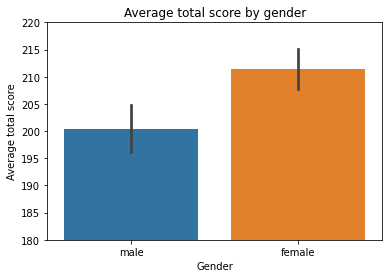

Male's average total score: 200.413
Female's average total score: 211.405


In [25]:
fig = plt.figure()

_ = sns.barplot(x = data.gender, y = data.total_score)
_.set_ylim((180, 220))
_.set_ylabel('Average total score')
_.set_xlabel('Gender')
_.set_title('Average total score by gender')
plt.show()

print("Male's average total score: {}".format(round(np.mean(data.total_score.loc[data.gender == 'male']), 3)))
print("Female's average total score: {}".format(round(np.mean(data.total_score.loc[data.gender == 'female']), 3)))



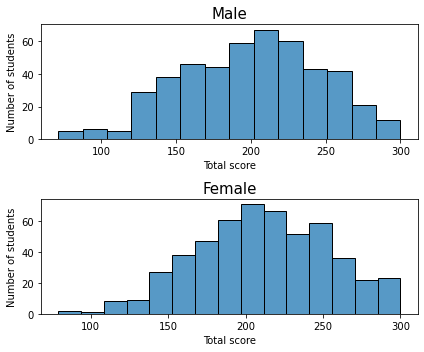

In [26]:
fig, ax = plt.subplots(2, 1, figsize = (6, 5))

male_plot = sns.histplot(data = data.loc[(data['gender'] == 'male'), 'total_score'], ax = ax[0])
male_plot.set_title('Male', fontsize = 15)
male_plot.set_ylabel('Number of students')
male_plot.set_xlabel('Total score')


female_plot = sns.histplot(data = data.loc[(data['gender'] == 'female'), 'total_score'], ax = ax[1])
female_plot.set_title('Female', fontsize = 15)
female_plot.set_ylabel('Number of students')
female_plot.set_xlabel('Total score')

fig.tight_layout()
plt.show()


We can see that there are not big differences in the test results based on the gender of the student. In fact, we have that the mean of the scores are similar - almost 10 points of difference -, and the distribution of the scores are approximately the same.

#### Average total score by race/ethnicity

In [27]:
data.race.value_counts().sort_index()

group A     85
group B    218
group C    298
group D    269
group E    130
Name: race, dtype: int64

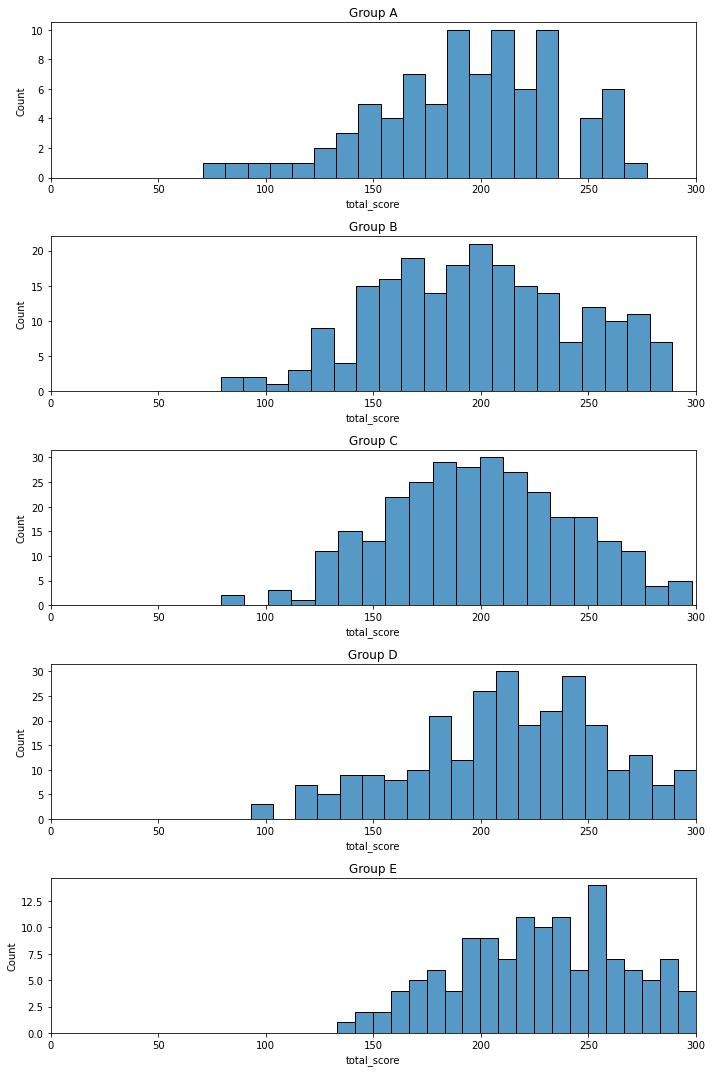

In [28]:
fig, ax = plt.subplots(5, 1, figsize = (10, 15))

groupA_plot = sns.histplot(data = data.loc[(data['race'] == 'group A'), 'total_score'], ax = ax[0], bins = 20)
_ = groupA_plot.set_title('Group A')
_ = groupA_plot.set_xlim((0, 300))

groupB_plot = sns.histplot(data = data.loc[(data['race'] == 'group B'), 'total_score'], ax = ax[1], bins = 20)
_ = groupB_plot.set_title('Group B')
_ = groupB_plot.set_xlim((0, 300))

groupC_plot = sns.histplot(data = data.loc[(data['race'] == 'group C'), 'total_score'], ax = ax[2], bins = 20)
_ = groupC_plot.set_title('Group C')
_ = groupC_plot.set_xlim((0, 300))

groupD_plot = sns.histplot(data = data.loc[(data['race'] == 'group D'), 'total_score'], ax = ax[3], bins = 20)
_ = groupD_plot.set_title('Group D')
_ = groupD_plot.set_xlim((0, 300))

groupE_plot = sns.histplot(data = data.loc[(data['race'] == 'group E'), 'total_score'], ax = ax[4], bins = 20)
_ = groupE_plot.set_title('Group E')
_ = groupE_plot.set_xlim((0, 300))

fig.tight_layout()


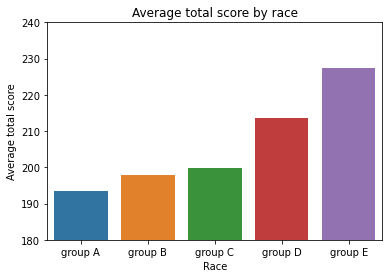

Max and min total score by race
            max        mean    min
race                             
group A  277.0  193.588235   71.0
group B  289.0  197.889908   79.0
group C  298.0  199.899329   79.0
group D  300.0  213.501859   93.0
group E  300.0  227.423077  133.0


In [29]:
avg_total_race = data.groupby('race')['total_score'].mean()
_ = sns.barplot(x = avg_total_race.index, y = avg_total_race.values)
_.set_ylim((180, 240))
_.set_title('Average total score by race', fontsize = 12)
_.set_xlabel('Race')
_.set_ylabel('Average total score')
plt.show()

print('Max and min total score by race\n', pd.pivot_table(data = data, 
                                                          index = 'race', 
                                                          values = 'total_score', 
                                                          aggfunc = (min, max, np.mean),
                                                          ))


Here we can see that there is a huge gap between the groups  D and E total scores mean - 214 and 227 - and the groups A, B and C - 194, 198, 200. Also, the distribution are different, where the group E students scores are between 133 and 300, while all the others gropus have the minimum lower than 100. 

Let's implement these analysis with what we have don before.

In [30]:
table = pd.pivot_table(data, 
               index = ['race', 'parental_education'], 
               values = ['total_score'], aggfunc = [np.mean, len])

table

mean         len
                           total_score total_score
race    parental_education                        
group A associate's degree  198.923077          13
        bachelor's degree   204.571429           7
        high school         189.744186          43
        master's degree     207.500000           8
        some college        187.000000          14
group B associate's degree  204.725000          40
        bachelor's degree   207.368421          19
        high school         179.775000          80
        master's degree     226.590909          22
        some college        204.280702          57
group C associate's degree  204.913043          69
        bachelor's degree   197.785714          42
        high school         190.715686         102
        master's degree     219.500000          20
        some college        204.323077          65
group D associate's degree  220.326923          52
        bachelor's degree   213.730769          26
        high school         201.095238         105
        master's degree     233.650000          20
        some college        221.666667          66
group E associate's degree  229.428571          21
        bachelor's degree   245.529412          17
        high school         222.117647          51
        master's degree     242.583333          12
        some college        218.413793          29

In [31]:
pt = {}
for group in np.sort(data['race'].unique()):
    pt[group] = {}
    mask_group = (data['race'] == str(group))
    tot_group = data[mask_group].shape[0]
    for level in data['parental_education'].unique():
        mask_level = mask_group & (data['parental_education'] == str(level))
        tot_lev = data[mask_level].shape[0]
        pt[group][level] = round(tot_lev/tot_group, 3)
pt = pd.DataFrame(pt)
pt

,group A,group B,group C,group D,group E
bachelor's degree,0.082,0.087,0.141,0.097,0.131
high school,0.506,0.367,0.342,0.390,0.392
some college,0.165,0.261,0.218,0.245,0.223
associate's degree,0.153,0.183,0.232,0.193,0.162
master's degree,0.094,0.101,0.067,0.074,0.092


From this table, we can see that the **race** factor could be correlate with the **parental level of education**'s one. In fact, we have that half of people belonging to the group A has parents with at most an high school level of education, and we have seen that this category is the one with lower total score average. But, it is important to note also that people belonging to group E has higher total score average on each parental level of education category than all the others groups. Also, people from this group whose parents have at most an high school diploma have an average total score greater than people whose parents have a Master's degree belonging to others groups race - A and C - and similar to group B.

Thus, I would say that the race factor could be stronger than the parental level of education's one in order to define which factor contributes the most. 

Finally, let's see if race influence the fact that a student took the test preparation course.

In [32]:
table = pd.pivot_table(data, 
               index = ['race'], 
               values = ['total_score'],
               columns = 'test_prep', 
               aggfunc = [np.mean, len], margins = True)
table

mean                                 len           
          total_score                         total_score           
test_prep   completed        none         All   completed none   All
race                                                                
group A    206.520000  188.200000  193.588235          25   60    85
group B    215.835443  187.690647  197.889908          79  139   218
group C    215.268041  192.482587  199.899329          97  201   298
group D    230.322222  205.044693  213.501859          90  179   269
group E    242.510204  218.296296  227.423077          49   81   130
All        222.667647  197.659091  206.162000         340  660  1000

From this last table we can see that the average total score of group E students who do not have completed the test preparation scores is higher than the average total score of people belonging to the group A, B and C. Thus, the ethnicity seems to be the most influencer factor in the test results. 

If this was a real case study, I think we should do further analysis to see why results from people of one ethnicity have better results overall respect to people from another one. Some possibilities are:

- Race bias from professors while evaluating exams;
- Different opportunity to study;
- Topic of the exams (if to closely related to one culture could be a problem for others).

## Conclusion

In conclusion, we have completed some analysis on data ideally provided us by a principal of a school, and we ended up saying that the test preparation course is very important to achieve better results on the final exams - remember the t test; but that there could be a problem related to the student's race/ethnicity that has to be investigate. 

We also conclude that student's gender do not make such a difference on the final score, as well as the lunch fare - analysis are not included in this notebook to not make it too long.

What I would suggest to the principal would be:
- Look for race/ethnicity bias in the school - the ones listed before.
- Improve the quantity of students that attend the test preparation course. An extreme case would be to make it mandatory, but there could be other solutions - different hours, different location, different modalities.

